# Training : ControlNet
- Ref: https://huggingface.co/docs/diffusers/v0.34.0/en/training/controlnet


### 1. Setup acclerate

In [ ]:
! accelerate config default

### 2. Prepare a training script
- Ref: https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet.py

In [ ]:
%%writefile temp_train_controlnet.py



#!/usr/bin/env python
# coding=utf-8
# Copyright 2025 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import argparse
import contextlib
import gc
import logging
import math
import os
import random
import shutil
from pathlib import Path

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module


if is_wandb_available():
    import wandb

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
# check_min_version("0.35.0.dev0")

logger = get_logger(__name__)


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def log_validation(
    vae, text_encoder, tokenizer, unet, controlnet, args, accelerator, weight_dtype, step, is_final_validation=False
):
    logger.info("Running validation... ")

    if not is_final_validation:
        controlnet = accelerator.unwrap_model(controlnet)
    else:
        controlnet = ControlNetModel.from_pretrained(args.output_dir, torch_dtype=weight_dtype)

    pipeline = StableDiffusionControlNetPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet,
        controlnet=controlnet,
        safety_checker=None,
        revision=args.revision,
        variant=args.variant,
        torch_dtype=weight_dtype,
    )
    pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    if args.enable_xformers_memory_efficient_attention:
        pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    if len(args.validation_image) == len(args.validation_prompt):
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt
    elif len(args.validation_image) == 1:
        validation_images = args.validation_image * len(args.validation_prompt)
        validation_prompts = args.validation_prompt
    elif len(args.validation_prompt) == 1:
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt * len(args.validation_image)
    else:
        raise ValueError(
            "number of `args.validation_image` and `args.validation_prompt` should be checked in `parse_args`"
        )

    image_logs = []
    inference_ctx = contextlib.nullcontext() if is_final_validation else torch.autocast("cuda")

    for validation_prompt, validation_image in zip(validation_prompts, validation_images):
        validation_image = Image.open(validation_image).convert("RGB")

        images = []

        for _ in range(args.num_validation_images):
            with inference_ctx:
                image = pipeline(
                    validation_prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]

            images.append(image)

        image_logs.append(
            {"validation_image": validation_image, "images": images, "validation_prompt": validation_prompt}
        )

    tracker_key = "test" if is_final_validation else "validation"
    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                validation_image = log["validation_image"]

                formatted_images = [np.asarray(validation_image)]

                for image in images:
                    formatted_images.append(np.asarray(image))

                formatted_images = np.stack(formatted_images)

                tracker.writer.add_images(validation_prompt, formatted_images, step, dataformats="NHWC")
        elif tracker.name == "wandb":
            formatted_images = []

            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                validation_image = log["validation_image"]

                formatted_images.append(wandb.Image(validation_image, caption="Controlnet conditioning"))

                for image in images:
                    image = wandb.Image(image, caption=validation_prompt)
                    formatted_images.append(image)

            tracker.log({tracker_key: formatted_images})
        else:
            logger.warning(f"image logging not implemented for {tracker.name}")

    del pipeline
    gc.collect()
    torch.cuda.empty_cache()

    return image_logs


def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")


def save_model_card(repo_id: str, image_logs=None, base_model=str, repo_folder=None):
    img_str = ""
    if image_logs is not None:
        img_str = "You can find some example images below.\n\n"
        for i, log in enumerate(image_logs):
            images = log["images"]
            validation_prompt = log["validation_prompt"]
            validation_image = log["validation_image"]
            validation_image.save(os.path.join(repo_folder, "image_control.png"))
            img_str += f"prompt: {validation_prompt}\n"
            images = [validation_image] + images
            image_grid(images, 1, len(images)).save(os.path.join(repo_folder, f"images_{i}.png"))
            img_str += f"![images_{i})](./images_{i}.png)\n"

    model_description = f"""
# controlnet-{repo_id}

These are controlnet weights trained on {base_model} with new type of conditioning.
{img_str}
"""
    model_card = load_or_create_model_card(
        repo_id_or_path=repo_id,
        from_training=True,
        license="creativeml-openrail-m",
        base_model=base_model,
        model_description=model_description,
        inference=True,
    )

    tags = [
        "stable-diffusion",
        "stable-diffusion-diffusers",
        "text-to-image",
        "diffusers",
        "controlnet",
        "diffusers-training",
    ]
    model_card = populate_model_card(model_card, tags=tags)

    model_card.save(os.path.join(repo_folder, "README.md"))


def parse_args(input_args=None):
    parser = argparse.ArgumentParser(description="Simple example of a ControlNet training script.")
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str,
        default=None,
        required=True,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--controlnet_model_name_or_path",
        type=str,
        default=None,
        help="Path to pretrained controlnet model or model identifier from huggingface.co/models."
        " If not specified controlnet weights are initialized from unet.",
    )
    parser.add_argument(
        "--revision",
        type=str,
        default=None,
        required=False,
        help="Revision of pretrained model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--variant",
        type=str,
        default=None,
        help="Variant of the model files of the pretrained model identifier from huggingface.co/models, 'e.g.' fp16",
    )
    parser.add_argument(
        "--tokenizer_name",
        type=str,
        default=None,
        help="Pretrained tokenizer name or path if not the same as model_name",
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="controlnet-model",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
    parser.add_argument(
        "--resolution",
        type=int,
        default=512,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=4, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument("--num_train_epochs", type=int, default=1)
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help=(
            "Save a checkpoint of the training state every X updates. Checkpoints can be used for resuming training via `--resume_from_checkpoint`. "
            "In the case that the checkpoint is better than the final trained model, the checkpoint can also be used for inference."
            "Using a checkpoint for inference requires separate loading of the original pipeline and the individual checkpointed model components."
            "See https://huggingface.co/docs/diffusers/main/en/training/dreambooth#performing-inference-using-a-saved-checkpoint for step by step"
            "instructions."
        ),
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help=("Max number of checkpoints to store."),
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help=(
            "Whether training should be resumed from a previous checkpoint. Use a path saved by"
            ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
        ),
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--gradient_checkpointing",
        action="store_true",
        help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=5e-6,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--scale_lr",
        action="store_true",
        default=False,
        help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="constant",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--lr_warmup_steps", type=int, default=500, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument(
        "--lr_num_cycles",
        type=int,
        default=1,
        help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
    )
    parser.add_argument("--lr_power", type=float, default=1.0, help="Power factor of the polynomial scheduler.")
    parser.add_argument(
        "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
        ),
    )
    parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
    parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="The name of the repository to keep in sync with the local `output_dir`.",
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument(
        "--allow_tf32",
        action="store_true",
        help=(
            "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
            " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
        ),
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default=None,
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
            " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
            " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
        ),
    )
    parser.add_argument(
        "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
    )
    parser.add_argument(
        "--set_grads_to_none",
        action="store_true",
        help=(
            "Save more memory by using setting grads to None instead of zero. Be aware, that this changes certain"
            " behaviors, so disable this argument if it causes any problems. More info:"
            " https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html"
        ),
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that 🤗 Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--image_column", type=str, default="image", help="The column of the dataset containing the target image."
    )
    parser.add_argument(
        "--conditioning_image_column",
        type=str,
        default="conditioning_image",
        help="The column of the dataset containing the controlnet conditioning image.",
    )
    parser.add_argument(
        "--caption_column",
        type=str,
        default="text",
        help="The column of the dataset containing a caption or a list of captions.",
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--proportion_empty_prompts",
        type=float,
        default=0,
        help="Proportion of image prompts to be replaced with empty strings. Defaults to 0 (no prompt replacement).",
    )
    parser.add_argument(
        "--validation_prompt",
        type=str,
        default=None,
        nargs="+",
        help=(
            "A set of prompts evaluated every `--validation_steps` and logged to `--report_to`."
            " Provide either a matching number of `--validation_image`s, a single `--validation_image`"
            " to be used with all prompts, or a single prompt that will be used with all `--validation_image`s."
        ),
    )
    parser.add_argument(
        "--validation_image",
        type=str,
        default=None,
        nargs="+",
        help=(
            "A set of paths to the controlnet conditioning image be evaluated every `--validation_steps`"
            " and logged to `--report_to`. Provide either a matching number of `--validation_prompt`s, a"
            " a single `--validation_prompt` to be used with all `--validation_image`s, or a single"
            " `--validation_image` that will be used with all `--validation_prompt`s."
        ),
    )
    parser.add_argument(
        "--num_validation_images",
        type=int,
        default=4,
        help="Number of images to be generated for each `--validation_image`, `--validation_prompt` pair",
    )
    parser.add_argument(
        "--validation_steps",
        type=int,
        default=100,
        help=(
            "Run validation every X steps. Validation consists of running the prompt"
            " `args.validation_prompt` multiple times: `args.num_validation_images`"
            " and logging the images."
        ),
    )
    parser.add_argument(
        "--tracker_project_name",
        type=str,
        default="train_controlnet",
        help=(
            "The `project_name` argument passed to Accelerator.init_trackers for"
            " more information see https://huggingface.co/docs/accelerate/v0.17.0/en/package_reference/accelerator#accelerate.Accelerator"
        ),
    )

    if input_args is not None:
        args = parser.parse_args(input_args)
    else:
        args = parser.parse_args()

    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("Specify either `--dataset_name` or `--train_data_dir`")

    if args.proportion_empty_prompts < 0 or args.proportion_empty_prompts > 1:
        raise ValueError("`--proportion_empty_prompts` must be in the range [0, 1].")

    if args.validation_prompt is not None and args.validation_image is None:
        raise ValueError("`--validation_image` must be set if `--validation_prompt` is set")

    if args.validation_prompt is None and args.validation_image is not None:
        raise ValueError("`--validation_prompt` must be set if `--validation_image` is set")

    if (
        args.validation_image is not None
        and args.validation_prompt is not None
        and len(args.validation_image) != 1
        and len(args.validation_prompt) != 1
        and len(args.validation_image) != len(args.validation_prompt)
    ):
        raise ValueError(
            "Must provide either 1 `--validation_image`, 1 `--validation_prompt`,"
            " or the same number of `--validation_prompt`s and `--validation_image`s"
        )

    if args.resolution % 8 != 0:
        raise ValueError(
            "`--resolution` must be divisible by 8 for consistently sized encoded images between the VAE and the controlnet encoder."
        )

    return args


def make_train_dataset(args, tokenizer, accelerator):
    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        dataset = load_dataset(
            args.dataset_name,
            args.dataset_config_name,
            cache_dir=args.cache_dir,
            data_dir=args.train_data_dir,
        )
    else:
        if args.train_data_dir is not None:
            dataset = load_dataset(
                args.train_data_dir,
                cache_dir=args.cache_dir,
            )
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.0.0/en/dataset_script

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    if args.image_column is None:
        image_column = column_names[0]
        logger.info(f"image column defaulting to {image_column}")
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"`--image_column` value '{args.image_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    if args.caption_column is None:
        caption_column = column_names[1]
        logger.info(f"caption column defaulting to {caption_column}")
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"`--caption_column` value '{args.caption_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    if args.conditioning_image_column is None:
        conditioning_image_column = column_names[2]
        logger.info(f"conditioning image column defaulting to {conditioning_image_column}")
    else:
        conditioning_image_column = args.conditioning_image_column
        if conditioning_image_column not in column_names:
            raise ValueError(
                f"`--conditioning_image_column` value '{args.conditioning_image_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if random.random() < args.proportion_empty_prompts:
                captions.append("")
            elif isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids

    image_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    conditioning_image_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        images = [image_transforms(image) for image in images]

        conditioning_images = [image.convert("RGB") for image in examples[conditioning_image_column]]
        conditioning_images = [conditioning_image_transforms(image) for image in conditioning_images]

        examples["pixel_values"] = images
        examples["conditioning_pixel_values"] = conditioning_images
        examples["input_ids"] = tokenize_captions(examples)

        return examples

    with accelerator.main_process_first():
        if args.max_train_samples is not None:
            dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
        # Set the training transforms
        train_dataset = dataset["train"].with_transform(preprocess_train)

    return train_dataset


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "input_ids": input_ids,
    }


def main(args):
    if args.report_to == "wandb" and args.hub_token is not None:
        raise ValueError(
            "You cannot use both --report_to=wandb and --hub_token due to a security risk of exposing your token."
            " Please use `huggingface-cli login` to authenticate with the Hub."
        )

    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
    )

    # Disable AMP for MPS.
    if torch.backends.mps.is_available():
        accelerator.native_amp = False

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

        if args.push_to_hub:
            repo_id = create_repo(
                repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
            ).repo_id

    # Load the tokenizer
    if args.tokenizer_name:
        tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, revision=args.revision, use_fast=False)
    elif args.pretrained_model_name_or_path:
        tokenizer = AutoTokenizer.from_pretrained(
            args.pretrained_model_name_or_path,
            subfolder="tokenizer",
            revision=args.revision,
            use_fast=False,
        )

    # import correct text encoder class
    text_encoder_cls = import_model_class_from_model_name_or_path(args.pretrained_model_name_or_path, args.revision)

    # Load scheduler and models
    noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
    text_encoder = text_encoder_cls.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision, variant=args.variant
    )
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision, variant=args.variant
    )
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision, variant=args.variant
    )

    if args.controlnet_model_name_or_path:
        logger.info("Loading existing controlnet weights")
        controlnet = ControlNetModel.from_pretrained(args.controlnet_model_name_or_path)
    else:
        logger.info("Initializing controlnet weights from unet")
        controlnet = ControlNetModel.from_unet(unet)

    # Taken from [Sayak Paul's Diffusers PR #6511](https://github.com/huggingface/diffusers/pull/6511/files)
    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model

    # `accelerate` 0.16.0 will have better support for customized saving
    if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
        # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
        def save_model_hook(models, weights, output_dir):
            if accelerator.is_main_process:
                i = len(weights) - 1

                while len(weights) > 0:
                    weights.pop()
                    model = models[i]

                    sub_dir = "controlnet"
                    model.save_pretrained(os.path.join(output_dir, sub_dir))

                    i -= 1

        def load_model_hook(models, input_dir):
            while len(models) > 0:
                # pop models so that they are not loaded again
                model = models.pop()

                # load diffusers style into model
                load_model = ControlNetModel.from_pretrained(input_dir, subfolder="controlnet")
                model.register_to_config(**load_model.config)

                model.load_state_dict(load_model.state_dict())
                del load_model

        accelerator.register_save_state_pre_hook(save_model_hook)
        accelerator.register_load_state_pre_hook(load_model_hook)

    vae.requires_grad_(False)
    unet.requires_grad_(False)
    text_encoder.requires_grad_(False)
    controlnet.train()

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warning(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            unet.enable_xformers_memory_efficient_attention()
            controlnet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError("xformers is not available. Make sure it is installed correctly")

    if args.gradient_checkpointing:
        controlnet.enable_gradient_checkpointing()

    # Check that all trainable models are in full precision
    low_precision_error_string = (
        " Please make sure to always have all model weights in full float32 precision when starting training - even if"
        " doing mixed precision training, copy of the weights should still be float32."
    )

    if unwrap_model(controlnet).dtype != torch.float32:
        raise ValueError(
            f"Controlnet loaded as datatype {unwrap_model(controlnet).dtype}. {low_precision_error_string}"
        )

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    if args.allow_tf32:
        torch.backends.cuda.matmul.allow_tf32 = True

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
        )

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
            )

        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    # Optimizer creation
    params_to_optimize = controlnet.parameters()
    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    train_dataset = make_train_dataset(args, tokenizer, accelerator)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

    # Scheduler and math around the number of training steps.
    # Check the PR https://github.com/huggingface/diffusers/pull/8312 for detailed explanation.
    num_warmup_steps_for_scheduler = args.lr_warmup_steps * accelerator.num_processes
    if args.max_train_steps is None:
        len_train_dataloader_after_sharding = math.ceil(len(train_dataloader) / accelerator.num_processes)
        num_update_steps_per_epoch = math.ceil(len_train_dataloader_after_sharding / args.gradient_accumulation_steps)
        num_training_steps_for_scheduler = (
            args.num_train_epochs * num_update_steps_per_epoch * accelerator.num_processes
        )
    else:
        num_training_steps_for_scheduler = args.max_train_steps * accelerator.num_processes

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps_for_scheduler,
        num_training_steps=num_training_steps_for_scheduler,
        num_cycles=args.lr_num_cycles,
        power=args.lr_power,
    )

    # Prepare everything with our `accelerator`.
    controlnet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        controlnet, optimizer, train_dataloader, lr_scheduler
    )

    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae, unet and text_encoder to device and cast to weight_dtype
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        if num_training_steps_for_scheduler != args.max_train_steps * accelerator.num_processes:
            logger.warning(
                f"The length of the 'train_dataloader' after 'accelerator.prepare' ({len(train_dataloader)}) does not match "
                f"the expected length ({len_train_dataloader_after_sharding}) when the learning rate scheduler was created. "
                f"This inconsistency may result in the learning rate scheduler not functioning properly."
            )
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        tracker_config = dict(vars(args))

        # tensorboard cannot handle list types for config
        tracker_config.pop("validation_prompt")
        tracker_config.pop("validation_image")

        accelerator.init_trackers(args.tracker_project_name, config=tracker_config)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch
    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, args.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )

    image_logs = None
    for epoch in range(first_epoch, args.num_train_epochs):
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(controlnet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents.float(), noise.float(), timesteps).to(
                    dtype=weight_dtype
                )

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"], return_dict=False)[0]

                controlnet_image = batch["conditioning_pixel_values"].to(dtype=weight_dtype)

                down_block_res_samples, mid_block_res_sample = controlnet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=encoder_hidden_states,
                    controlnet_cond=controlnet_image,
                    return_dict=False,
                )

                # Predict the noise residual
                model_pred = unet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=encoder_hidden_states,
                    down_block_additional_residuals=[
                        sample.to(dtype=weight_dtype) for sample in down_block_res_samples
                    ],
                    mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
                    return_dict=False,
                )[0]

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    params_to_clip = controlnet.parameters()
                    accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad(set_to_none=args.set_grads_to_none)

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process:
                    if global_step % args.checkpointing_steps == 0:
                        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                                removing_checkpoints = checkpoints[0:num_to_remove]

                                logger.info(
                                    f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                                )
                                logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                                for removing_checkpoint in removing_checkpoints:
                                    removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                    shutil.rmtree(removing_checkpoint)

                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

                    if args.validation_prompt is not None and global_step % args.validation_steps == 0:
                        image_logs = log_validation(
                            vae,
                            text_encoder,
                            tokenizer,
                            unet,
                            controlnet,
                            args,
                            accelerator,
                            weight_dtype,
                            global_step,
                        )

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break

    # Create the pipeline using the trained modules and save it.
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        controlnet = unwrap_model(controlnet)
        controlnet.save_pretrained(args.output_dir)

        # Run a final round of validation.
        image_logs = None
        if args.validation_prompt is not None:
            image_logs = log_validation(
                vae=vae,
                text_encoder=text_encoder,
                tokenizer=tokenizer,
                unet=unet,
                controlnet=None,
                args=args,
                accelerator=accelerator,
                weight_dtype=weight_dtype,
                step=global_step,
                is_final_validation=True,
            )

        if args.push_to_hub:
            save_model_card(
                repo_id,
                image_logs=image_logs,
                base_model=args.pretrained_model_name_or_path,
                repo_folder=args.output_dir,
            )
            upload_folder(
                repo_id=repo_id,
                folder_path=args.output_dir,
                commit_message="End of training",
                ignore_patterns=["step_*", "epoch_*"],
            )

    accelerator.end_training()


if __name__ == "__main__":
    args = parse_args()
    main(args)

### 3. Train 

In [ ]:
! wget https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet_training/conditioning_image_1.png
! wget https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet_training/conditioning_image_2.png

In [ ]:
# MODEL_DIR="stable-diffusion-v1-5/stable-diffusion-v1-5"
# OUTPUT_DIR="path/to/save/model"

# ! accelerate launch temp_train_controlnet.py \
#  --pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5" \
#  --output_dir="./temp/controlnet" \
#  --dataset_name=fusing/fill50k \
#  --resolution=512 \
#  --learning_rate=1e-5 \
#  --validation_image "./conditioning_image_1.png" "./conditioning_image_2.png" \
#  --validation_prompt "red circle with blue background" "cyan circle with brown floral background" \
#  --train_batch_size=1 \
#  --gradient_accumulation_steps=4 \
#  --enable_xformers_memory_efficient_attention \
#  --gradient_checkpointing \
#  --mixed_precision="fp16"


! accelerate launch temp_train_controlnet.py \
 --pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5" \
 --output_dir="./temp/controlnet" \
 --dataset_name=fusing/fill50k \
 --resolution=512 \
 --learning_rate=1e-5 \
 --validation_image "./conditioning_image_1.png" "./conditioning_image_2.png" \
 --validation_prompt "red circle with blue background" "cyan circle with brown floral background" \
 --train_batch_size=1 \
 --gradient_accumulation_steps=4 \
 --gradient_checkpointing \
 --mixed_precision="fp16"

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(s_device)

cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

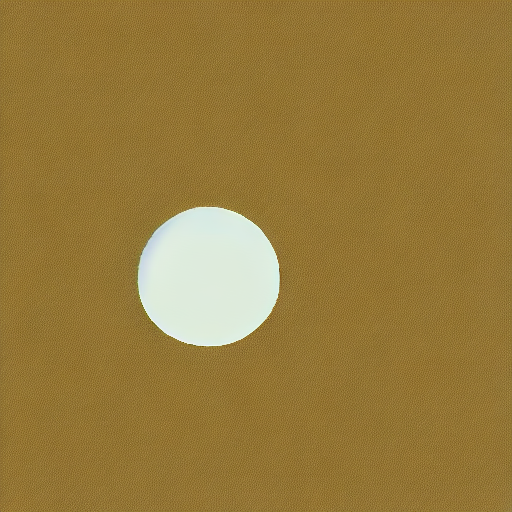

: 

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
import torch

controlnet = ControlNetModel.from_pretrained("./temp/controlnet/", torch_dtype=torch.float16)
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
).to(t_device)

control_image = load_image("./conditioning_image_2.png")
prompt = "pale golden rod circle with old lace background"
# prompt = "red circle with blue background" 

generator = torch.manual_seed(0)
# image = pipeline(prompt, num_inference_steps=100, generator=generator, image=control_image).images[0]
image = pipeline(prompt, num_inference_steps=100,image=control_image).images[0]
# image.save("./output.png")
image